In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import csv
import math

import tqdm
from tqdm import tqdm

from PIL import Image

# Load Images

In [ ]:
dirname = '/content/drive/MyDrive/CS 199/Cell Images/'

In [ ]:
labels = pd.read_csv(dirname + 'bbbc021_labels.csv', index_col=0)

In [ ]:
# Load images
Image = []
for image in tqdm(os.listdir(dirname + 'TRAINING SET')):
  Image.append(os.path.join(dirname + 'TRAINING SET', image))

100%|██████████| 4700/4700 [00:00<00:00, 432042.36it/s]


In [ ]:
# Arranging files with their file number
number = Image.copy()
for i in range(0, len(number)):
  number[i] = number[i].replace('/content/drive/MyDrive/CS 199/Cell Images/TRAINING SET/bbbc021_', '')
  number[i] = number[i].replace('.png', '')
  number[i] = int(number[i])

In [ ]:
Image_number = dict(zip(Image, number))
Image_number = sorted(Image_number, key = Image_number.get)

In [ ]:
labels['image'] = Image_number
#labels

# Data Preprocessing

In [ ]:
# Load values into arrays
moa            = np.array(labels['moa'])
compounds       = np.array(labels['compound'])
concentrations = np.array(labels['concentration'])
replicates     = np.array(labels['replicate'])
images         = np.array(labels['image'])
path           = '/content/drive/MyDrive/CS 199/Cell Images/TRAINING SET/bbbc021_'

In [ ]:
moa_dict = {
            'Actin disruptors': 0,          'Aurora kinase inhibitors': 1, 'Cholesterol-lowering': 2,
            'Eg5 inhibitors': 3,            'Epithelial': 4,               'Kinase inhibitors': 5,
            'Microtubule destabilizers': 6, 'Microtubule stabilizers': 7,  'Protein degradation': 8,
            'Protein synthesis': 9,         'DNA replication': 10,         'DNA damage': 11
            }

In [ ]:
# Randomly select 32 images from each compound in order for us to have a balanced dataset
image_selection =   labels.groupby(['compound']).sample(32)#.reset_index()
#image_selection

In [ ]:
# Split image selection to Train, Test, and Validation
train_images = image_selection.groupby(['compound']).sample(16)
image_selection = image_selection.drop(train_images.index)
test_images = image_selection.groupby(['compound']).sample(8)
image_selection = image_selection.drop(test_images.index)
val_images = image_selection.groupby(['compound']).sample(8)

# Image Preprocessing

In [ ]:
# Training Set
X_train = []
y_train = []
train_compounds = []

for i in tqdm(range(0, len(train_images))):
  # Load and resize images
  img = cv2.imread(train_images['image'].iloc[i])
  img = cv2.resize(img, (299, 299), interpolation=cv2.INTER_AREA)
  X_train.append(img)

  # Append MoA numerical values
  y_train.append(moa_dict[train_images['moa'].iloc[i]])
  train_compounds.append(train_images['compound'].iloc[i])

100%|██████████| 608/608 [05:43<00:00,  1.77it/s]


In [ ]:
# Test Set
X_test = []
y_test = []
test_compounds = []

for i in tqdm(range(0, len(test_images))):
  img = cv2.imread(test_images['image'].iloc[i])
  img = cv2.resize(img, (299,299), interpolation=cv2.INTER_AREA)
  X_test.append(img)
  y_test.append(moa_dict[test_images['moa'].iloc[i]])
  test_compounds.append(test_images['compound'].iloc[i])

100%|██████████| 304/304 [03:03<00:00,  1.66it/s]


In [ ]:
# Validation Set
X_val = []
y_val = []
val_compounds = []

for i in tqdm(range(0, len(val_images))):
  img = cv2.imread(val_images['image'].iloc[i])
  img = cv2.resize(img, (299,299), interpolation=cv2.INTER_AREA)
  X_val.append(img)
  y_val.append(moa_dict[val_images['moa'].iloc[i]])
  val_compounds.append(val_images['compound'].iloc[i])

100%|██████████| 304/304 [02:33<00:00,  1.98it/s]


In [ ]:
# def get_one_hot(targets, nb_classes):
#     res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
#     return res.reshape(list(targets.shape)+[nb_classes])

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_val = np.array(X_val)
y_val = np.array(y_val)

In [ ]:
# One-hot encoding 
# y = get_one_hot(y, 12)
# y_val = get_one_hot(y_val, 12)

from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((608, 299, 299, 3),
 (608, 12),
 (304, 299, 299, 3),
 (304, 12),
 (304, 299, 299, 3),
 (304, 12))

# Image Augmentation

In [ ]:
def noisy(image):
    row,col,ch= image.shape
    image = image.astype(np.float32)

    for i in range(ch):
        jitter_percent = np.random.choice([0., 0., .25, -.25])
        image[:,:,i] *= (1 - jitter_percent)
    if np.random.choice([0,1]) == 1:
        filter_size = 3
        image = cv2.blur(image,(filter_size,filter_size))
    if np.random.choice([0,1]) == 1:
        var   = 50
        sigma = var**0.5
        mean  = 0
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        image += gauss

    image[image < 0] = 0
    image[image > 255] = 255

    return image

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1, preprocessing_function=noisy)
test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True, zoom_range=.1)
val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(X_train)
test_generator.fit(X_test)
val_generator.fit(X_val)

In [ ]:
# Sample save image to folder
save_image = train_generator.flow(X_train, y_train, batch_size = 8)

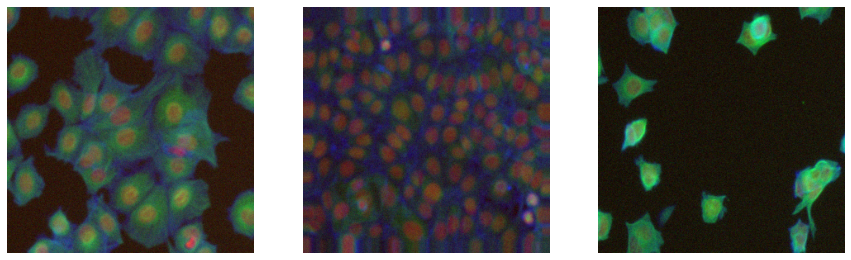

In [ ]:
# Preview images from ImageDataGenerator
aug_iter = train_generator.flow(X_train, y_train, batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
 
	# plot image
	ax[i].imshow(image[0])
	ax[i].axis('off')

# Model building


In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

from keras.callbacks import CSVLogger
from keras.callbacks import LearningRateScheduler
from keras import regularizers

def create_model():
    # Creating model with pre trained imagenet weights
    model = InceptionResNetV2(include_top = False, weights='imagenet', input_shape=(299, 299, 3), classes=y_train.shape[1]) # Resize images to 299 x 299

    # We dont want to train all layers, so we do the following step 
    for layers in model.layers:
        layers.trainable = True

    x = Flatten()(model.output)
    x = GlobalAveragePooling2D(name='avg_pool')(model.output)
    x = Dense(12, kernel_regularizer=regularizers.l2(0.0), activation='softmax', name='predictions')(x)

    # Dense & Output Layer

    # dense_layer_1 = Dense(units = 64, activation = tf.nn.leaky_relu)(x) # consider 48, 64 units
    # dropout_1   = Dropout(0.3)(dense_layer_1)

    # dense_layer_2 = Dense(units = 32, activation = tf.nn.leaky_relu)(dropout_1) # consider 24, 32 units
    # dropout_2   = Dropout(0.3)(dense_layer_2)

    # final_layer = Dense(units = 12, activation = 'softmax')(dropout_2)

    model = Model(inputs = model.input, outputs = x)

    model.compile(optimizer = 'Adam', 
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

# Run

In [ ]:
compound_list = ["PP-2",           "AZ-J",                 "AZ-U",                                     # Epithelial
             "colchicine",     "vincristine",          "demecolcine",   "nocodazole",              # Microtubule destabilizers
             "docetaxel",      "taxol",                "epothilone B",                             # Microtubule stabilizers
             "ALLN",           "lactacystin",          "MG-132",        "proteasome inhibitor I",  # Protein degradation
             "anisomycin",     "emetine",              "cyclohexamide",                            # Protein synthesis
             "alsterpaullone", "bryostatin",           "PD-169316",                                # Kinase inhibitors
             "AZ138",          "AZ-C",                                                             # Eg-5 inhibitors
             "floxuridine",    "mitoxantrone",         "methotrexate",  "camptothecin",            # DNA-replication
             "etoposide",      "chlorambucil",         "cisplatin",     "mitomycin C",             # DNA-damage
             "simvastatin",    "mevinolin/lovastatin",                                             # Cholesterol-lowering
             "AZ841",          "AZ-A",                 "AZ258",                                    # Aurora kinase inhibitors
             "cytochalasin B", "latrunculin B",        "cytochalasin D"]                           # Actin disruptors

In [ ]:
model = create_model()

219062272/219055592 [==============================] - 28s 0us/step


In [ ]:
# Callbacks
# Learning Rate Annealer
from keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5)

In [ ]:
#Initializing the hyperparameters
batch_size= 8

In [ ]:
from keras import backend as K 
K.clear_session()
model.fit(train_generator.flow(X_train, y_train, batch_size= batch_size), # save_to_dir='train images'
                    epochs = 30, 
                    # steps_per_epoch = X_train.shape[0]//batch_size, 
                    validation_data = val_generator.flow(X_val, y_val, batch_size = batch_size), # save_to_dir='val images' 
                    # validation_steps = X_test.shape[0]//batch_size, 
                    callbacks=[lrr], 
                    verbose = 1)

Epoch 1/30
76/76 [==============================] - 130s 1s/step - loss: 2.2393 - accuracy: 0.2294 - val_loss: 7.2324 - val_accuracy: 0.1447
Epoch 2/30
76/76 [==============================] - 72s 947ms/step - loss: 1.4074 - accuracy: 0.5080 - val_loss: 1.7312 - val_accuracy: 0.4507
Epoch 3/30
76/76 [==============================] - 72s 948ms/step - loss: 1.0613 - accuracy: 0.6367 - val_loss: 1.5890 - val_accuracy: 0.4704
Epoch 4/30
76/76 [==============================] - 72s 944ms/step - loss: 0.9898 - accuracy: 0.6857 - val_loss: 3.1605 - val_accuracy: 0.4046
Epoch 5/30
76/76 [==============================] - 72s 946ms/step - loss: 0.7940 - accuracy: 0.7348 - val_loss: 0.7399 - val_accuracy: 0.7039
Epoch 6/30
76/76 [==============================] - 72s 946ms/step - loss: 0.6377 - accuracy: 0.7868 - val_loss: 3.2996 - val_accuracy: 0.3980
Epoch 7/30
76/76 [==============================] - 72s 947ms/step - loss: 0.8624 - accuracy: 0.7135 - val_loss: 1.4940 - val_accuracy: 0.5888
E

# Predictions and Figures

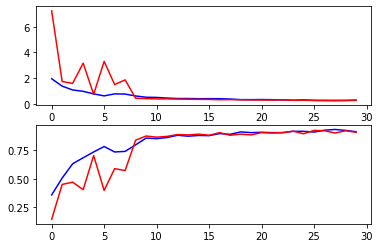

In [ ]:
#Plotting the training and validation loss and accuracy
f,ax=plt.subplots(2,1) 

#Loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')


In [ ]:
#Making prediction
y_pred=model.predict(X_test)
y_true=np.argmax(y_test,axis=1)

In [ ]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Confusion matrix, without normalization


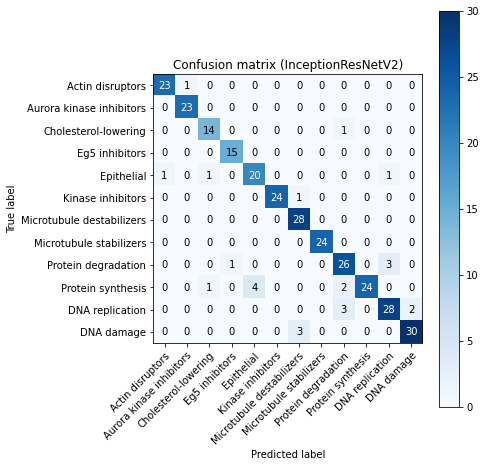

In [ ]:
from sklearn.metrics import confusion_matrix

#Plotting the confusion matrix
confusion_mtx = confusion_matrix(y_pred.argmax(axis=1), y_true)

#Defining the class labels
class_names=moa_dict.keys()

# Plotting non-normalized confusion matrix
# plot_confusion_matrix(y_true, y_pred, classes = class_names, title='Confusion matrix, without normalization')
plot_confusion_matrix(y_pred.argmax(axis=1), y_true, classes = class_names, title='Confusion matrix (InceptionResNetV2)')

Normalized confusion matrix


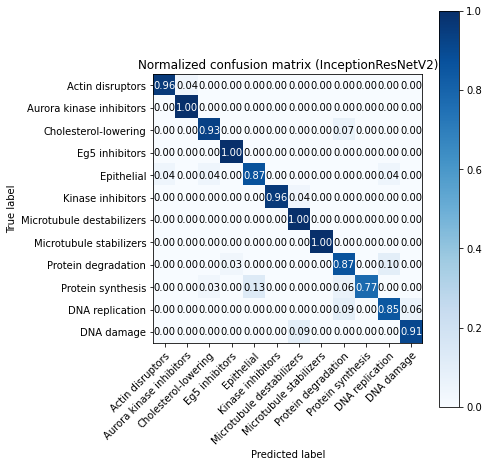

In [ ]:
plot_confusion_matrix(y_pred.argmax(axis=1), y_true, normalize=True, classes = class_names, title='Normalized confusion matrix (InceptionResNetV2)')

# Download Test Set for Review


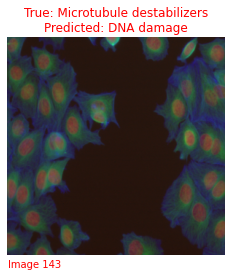

In [ ]:
i = 143
true_label = list(moa_dict.keys())[int(y_true[i])]
predicted_label = list(moa_dict.keys())[np.where(y_pred[i] == np.amax(y_pred[i]))[0][0]]

if true_label != predicted_label:
  plt.rcParams['text.color'] = 'red'
else: plt.rcParams['text.color'] = 'black'

plt.title('True: ' + true_label + '\n' +
          'Predicted: ' + predicted_label)
plt.text(.5, 315, 'Image '+ str(i))
plt.axis('off')
plt.imshow(X_test[i])

In [ ]:
# for i in tqdm(range(0, len(X_test))):
#   true_label = list(moa_dict.keys())[int(y_true[i])]
#   predicted_label = list(moa_dict.keys())[np.where(y_pred[i] == np.amax(y_pred[i]))[0][0]]

#   if true_label != predicted_label:
#     plt.rcParams['text.color'] = 'red'
#   else: plt.rcParams['text.color'] = 'black'

#   plt.title('True: ' + true_label + '\n' +
#             'Predicted: ' + predicted_label)
#   plt.text(.5, 315, 'Image '+ str(i))
#   plt.axis('off')
#   plt.imshow(X_test[i])
#   plt.savefig('/content/drive/MyDrive/CS 199/Test Images Results (MS)/' + str(i) + '.png')
#   plt.clf()

100%|██████████| 304/304 [00:42<00:00,  7.10it/s]


<Figure size 432x288 with 0 Axes>